In [1]:
!pip install -q patchify
!pip install -q timm 

In [2]:
!nvidia-smi

Mon Jul 25 13:52:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!curl --output SMACS0723.png https://stsci-opo.org/STScI-01G8H15R2PGEXQD7TYYBFJ3FT4.png


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.5M  100 28.5M    0     0  56.3M      0 --:--:-- --:--:-- --:--:-- 56.4M


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import patchify
from PIL import Image
import torch
import tqdm
import timm

In [5]:
def load_image(filename):
    "Open and load a `PIL.Image` -- convenience function from fastai"
    im = Image.open(filename)
    im.load()
    return im._new(im.im)

def show_image(img, ax=None, figsize=(3,3), **kwargs):
    """Quickly plot an image in a new or exisitng plt.Axis object -- 
    also adapted from fastai.
    """
    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img, **kwargs)
    ax.axis('off')
    return ax

In [6]:
im = load_image("SMACS0723.png")
im_array = np.array(im)
im_array = im_array.transpose((2, 0, 1))

In [7]:
size = 144
patches = patchify.patchify(im_array, (3, size, size), step=size)
patches = patches.reshape((-1, 3, size, size))


In [8]:
patches.shape

(992, 3, 144, 144)

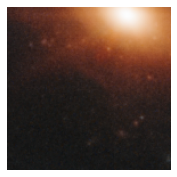

In [9]:
show_image(patches[845].transpose(1, 2, 0))

In [10]:
def transpose_image(im):
    return im.transpose(1, 2, 0)

In [11]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext

In [12]:
model = timm.create_model('convnext_base_in22k', pretrained=True).cuda()


In [13]:
batch_size = 32

In [14]:
padding = np.zeros(((batch_size - patches.shape[0] % batch_size), *patches.shape[1:]))


In [15]:
N_batches = (len(patches) + len(padding)) // batch_size


In [16]:
batched_patches = np.split(np.concatenate([patches, padding]), N_batches)


In [17]:
features = []
for batch in tqdm.tqdm(batched_patches, total=N_batches):
    feat = model(torch.tensor(batch).float().cuda())
    features.append(feat.cpu().detach().numpy())

100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


In [18]:
f = np.concatenate(features)
N_feat = f.shape[-1]

f = f.reshape(-1, N_feat)

# drop padding
f = f[:-len(padding)]

In [19]:
f.shape

(992, 21841)

In [20]:
from scipy.spatial import KDTree

In [21]:
kdt = KDTree(f)

In [22]:
def transpose_image(im):
    return im.transpose(1, 2, 0)

def plot_nearest_patches(index, vmin=0, vmax=200):
    show_image(transpose_image(patches[index]), figsize=(4.5, 4.5), vmin=vmin, vmax=vmax)

    dists, inds = kdt.query(f[index], k=[2, 3, 4, 5])
    print(inds)

    fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=150)
    for ind, ax in zip(inds, axes.flat):
        show_image(transpose_image(patches[ind]), ax=ax, vmin=vmin, vmax=vmax)

[294 640 218 768]


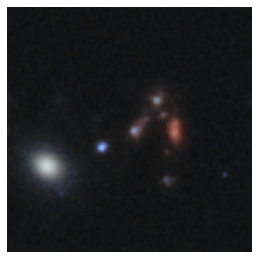

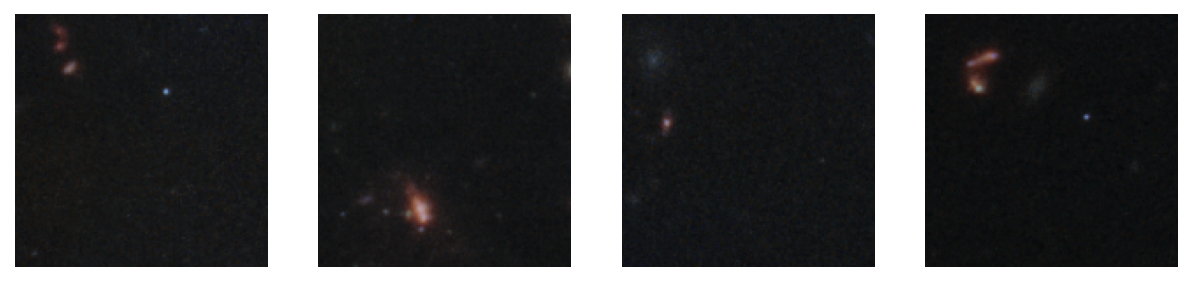

In [23]:
plot_nearest_patches(251)


[  1 617 384 287]


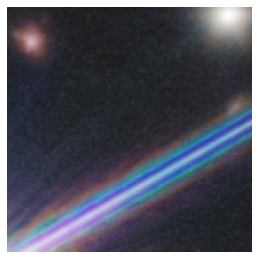

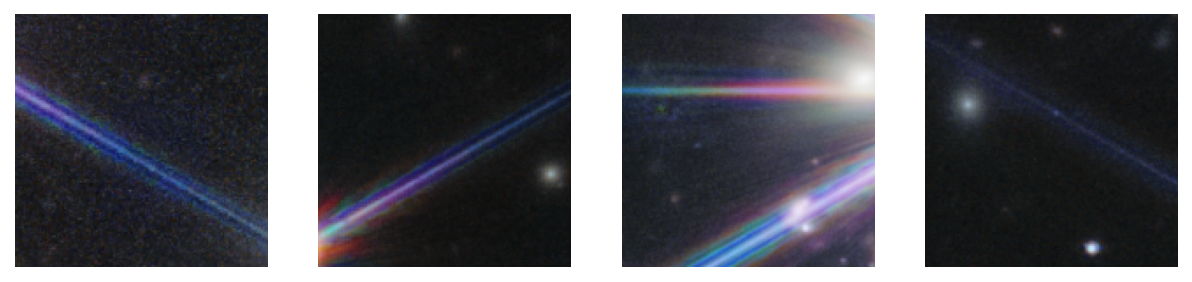

In [24]:
plot_nearest_patches(355)


[ 44 867 447  31]


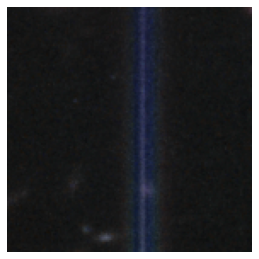

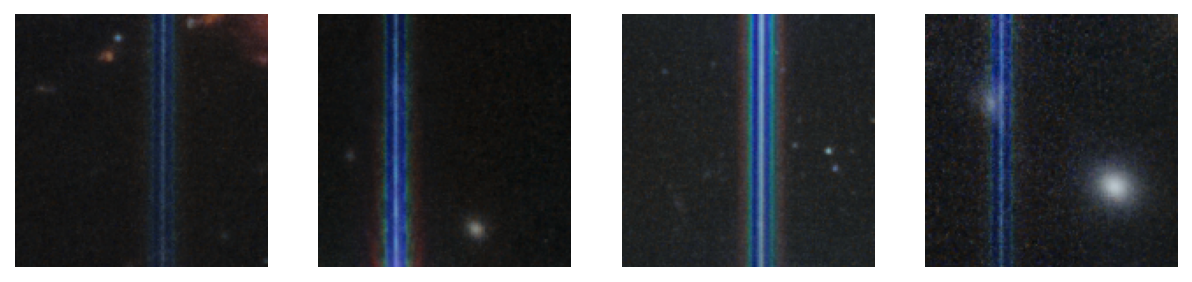

In [25]:
plot_nearest_patches(230)


[452 482 512 543]


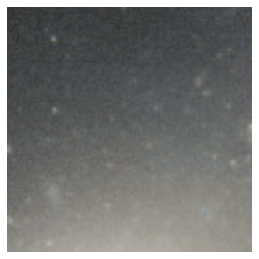

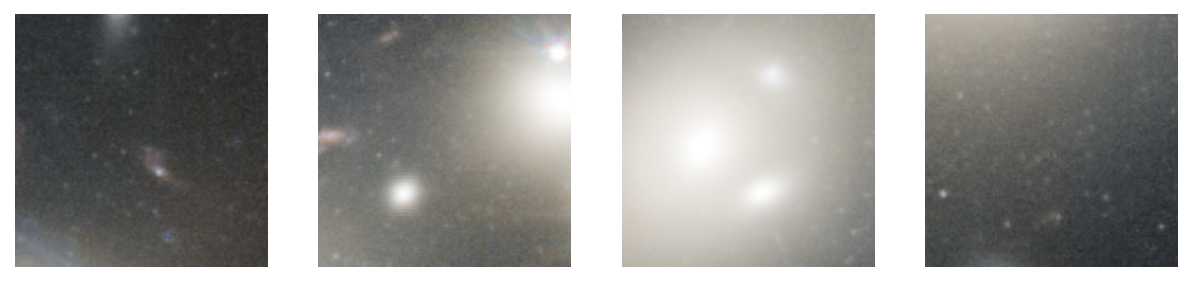

In [26]:
plot_nearest_patches(481)


[447 478 416 867]


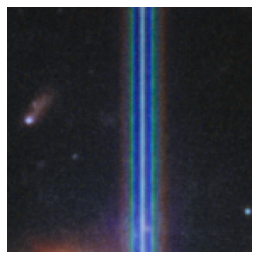

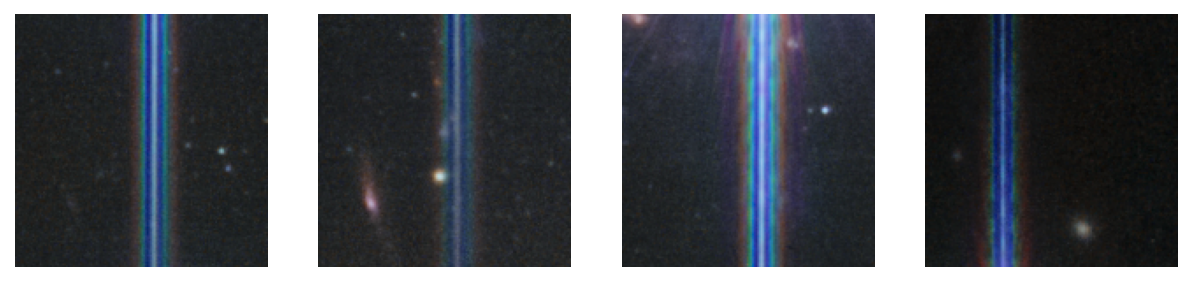

In [27]:
plot_nearest_patches(323)


[112  84 264 257]


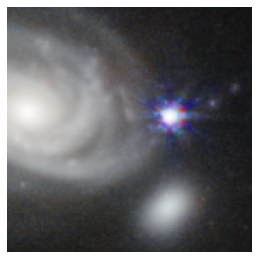

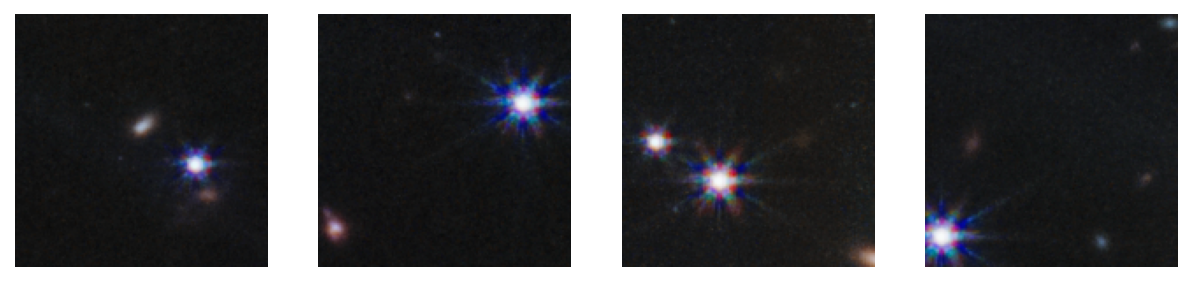

In [28]:
plot_nearest_patches(399)


[ 45 642 129 947]


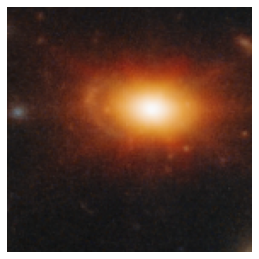

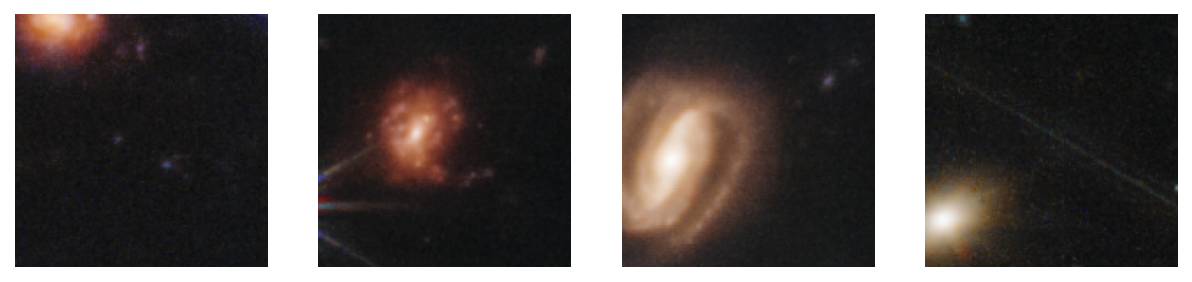

In [29]:
plot_nearest_patches(729)


[ 45 129 588 972]


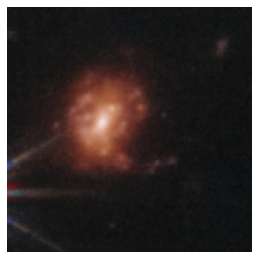

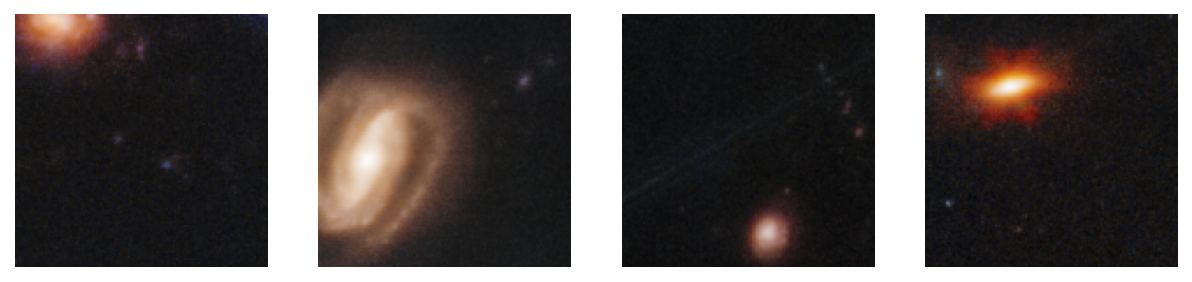

In [30]:
plot_nearest_patches(642)


# Query other images

In [31]:
! curl --output image-query.png https://i.ibb.co/QY3SZhP/image.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93450  100 93450    0     0   822k      0 --:--:-- --:--:-- --:--:--  822k


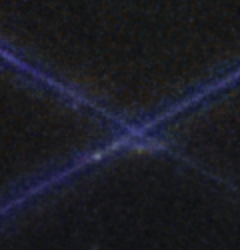

In [32]:
im_query = load_image("image-query.png")
im_query

In [33]:
# our usual axis gymnastics... also this has an alpha channel which we don't want!
im_query = np.array(im_query).transpose(2, 0, 1)[None, :3, ...]

# send to gpu...
x = torch.tensor(im_query).float().cuda()

# pass through model...
f_query = model(x)

# send back from gpu
f_query = f_query.cpu().detach().numpy()

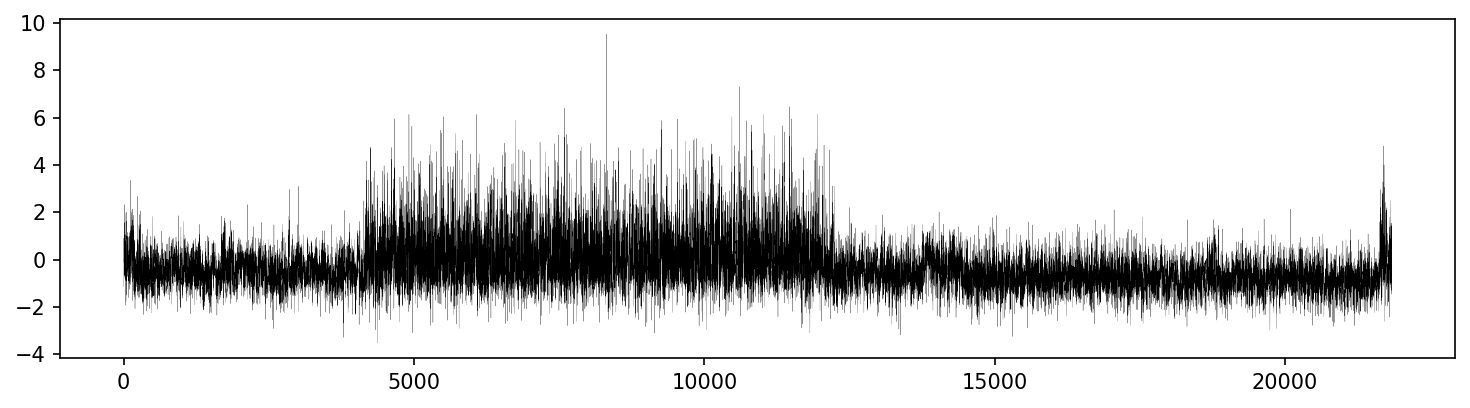

In [34]:
# a 22k dimensional vector
plt.figure(figsize=(12, 3), dpi=150)
plt.plot(f_query.flat, lw=0.1, c='k')

[  4  63 288  32 957 870 473 936 325 507]


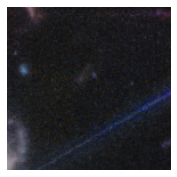

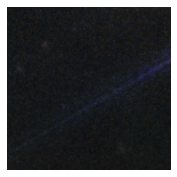

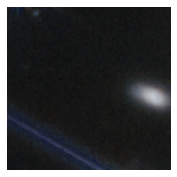

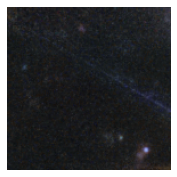

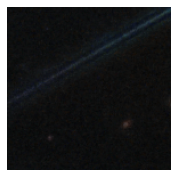

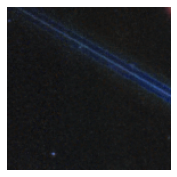

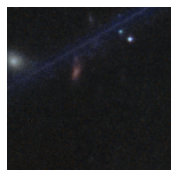

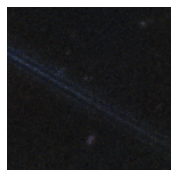

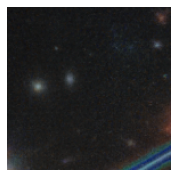

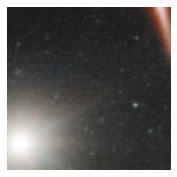

In [35]:
# get 10 nearest images
dists, inds = kdt.query(f_query.flat, k=10)
print(inds)

for ind in inds:
    show_image(transpose_image(patches[ind]), vmin=0, vmax=200)

In [36]:
# another image example
! curl --output image-query-2.png https://i.ibb.co/qWnwLT5/image.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115k  100  115k    0     0  1420k      0 --:--:-- --:--:-- --:--:-- 1420k


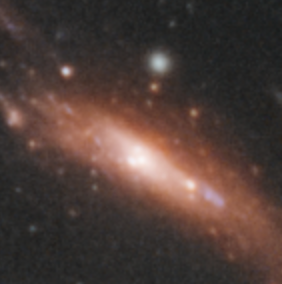

In [37]:
im_query = load_image("image-query-2.png")
im_query

[150  47 216 499 491 215 225 451 113 707]


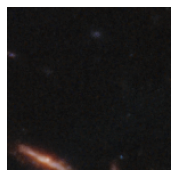

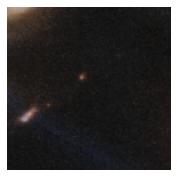

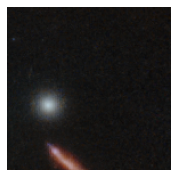

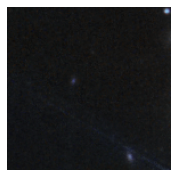

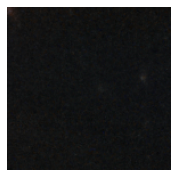

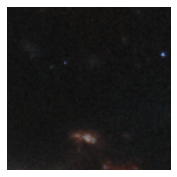

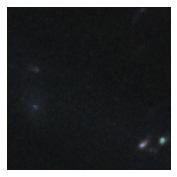

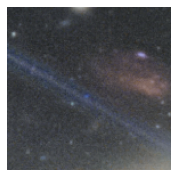

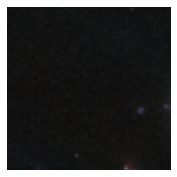

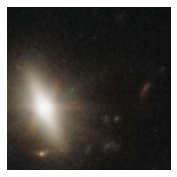

In [38]:
im_query = np.array(im_query).transpose(2, 0, 1)[None, :3, ...]
x = torch.tensor(im_query).float().cuda()
f_query = model(x)
f_query = f_query.cpu().detach().numpy()

# get 10 nearest images
dists, inds = kdt.query(f_query.flat, k=10)
print(inds)

for ind in inds:
    show_image(transpose_image(patches[ind]), vmin=0, vmax=200)